In [1]:
from tinyai import *

import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

set_output()
toggle_mpl_cmap()

setting cmap: gray_r


In [2]:
from datasets import load_dataset

dsd = load_dataset("fashion_mnist")

x,y = 'image','label'

import torchvision.transforms.functional as TF

xmean,xstd = 0.286, 0.353

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=8)

In [3]:
betamin, betamax, nsteps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, nsteps)
alpha = 1 - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

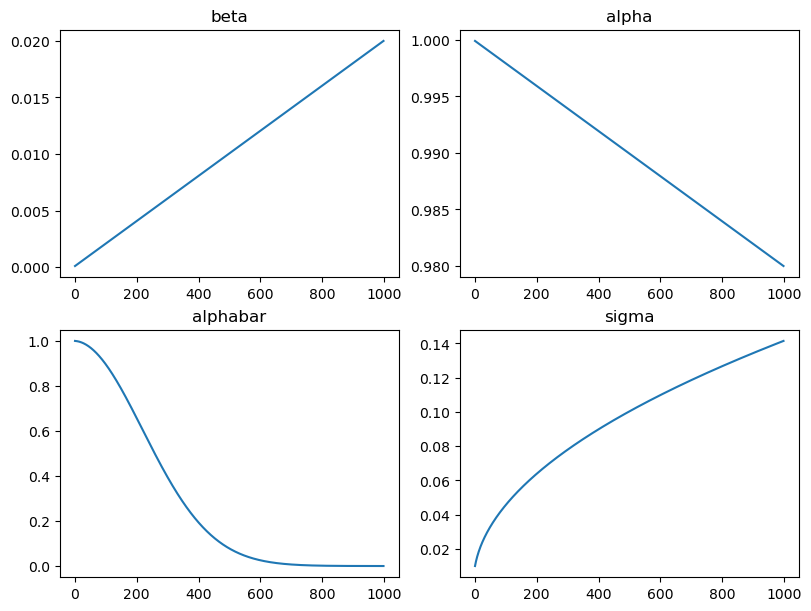

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
ax1.plot(beta); ax2.plot(alpha); ax3.plot(alphabar); ax4.plot(sigma)
ax1.set_title('beta'); ax2.set_title('alpha'); ax3.set_title('alphabar'); ax4.set_title('sigma')
plt.show()

Beta is the amount of variance added at each step, sigma is sqrt so is the **stdev** added at each step

Alpha bar is used with the cumprod, as if you add noise, then add more noise etc, the result is multipliying all the steps together up to that point

As t increases, the image gets more noisy. As the timesteps increase, this compounds until there is basically no information from the image.

x axis is t. When t is high, beta is higher (and alpha is lower)

- as t increases, alphabar drops and sigma increass

alpha is only from 1 - 0.98, this causes the cumprod to tend to 0 since numbers less than 0 * together will get smaller

- Epsilon: actual noise added -- also the target as the model predicts the noise

Example step

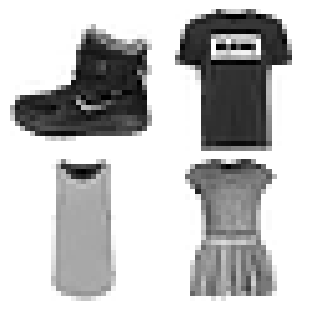

In [5]:
xb, _ = next(iter(dls.train))
xb= xb[:4]
show_images(xb, imsize=1.5)

In [6]:
bs = len(xb) # 4
t = torch.randint(0, nsteps, (bs,), dtype=torch.long)
print("t", t)
alphabar_t = alphabar[t]
print("alphabar_t", alphabar_t.shape)
print(f"alphabar_t: {alphabar_t}, sqrt(alphabar_t): {alphabar_t.sqrt()}")
scaled_xb = alphabar_t.reshape(-1, 1, 1, 1).sqrt() * xb
print("scaled_xb", scaled_xb.shape)


t tensor([394, 469, 846, 225])
alphabar_t torch.Size([4])
alphabar_t: tensor([0.203, 0.105, 0.001, 0.589]), sqrt(alphabar_t): tensor([0.451, 0.325, 0.026, 0.767])
scaled_xb torch.Size([4, 1, 28, 28])


In [7]:
(alphabar_t.reshape(-1, 1, 1, 1).sqrt() * xb).shape

torch.Size([4, 1, 28, 28])

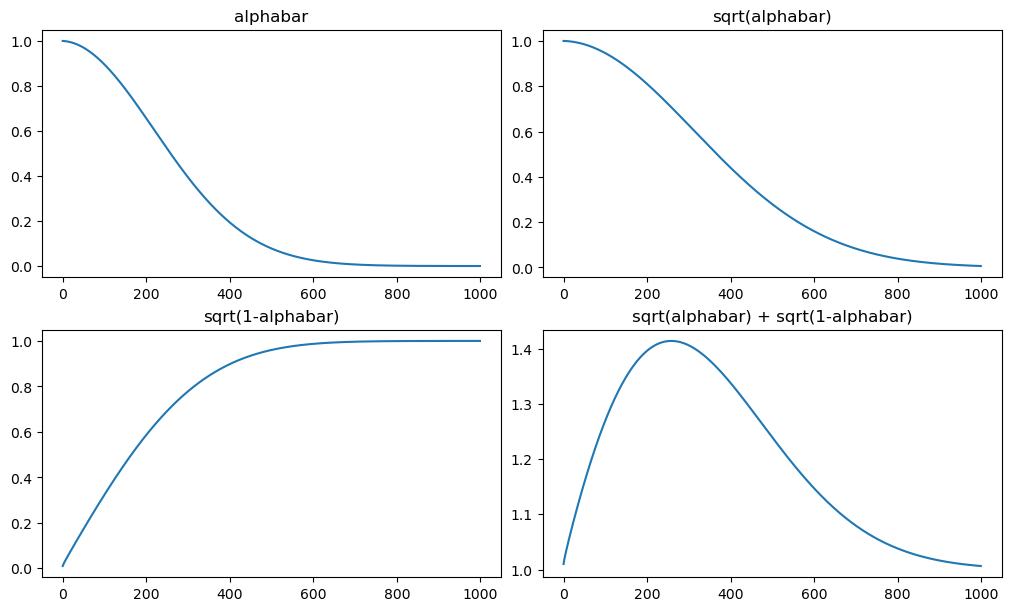

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
ax1.plot(alphabar); ax1.set_title('alphabar')
ax2.plot(alphabar.sqrt()); ax2.set_title('sqrt(alphabar)')
ax3.plot((1-alphabar).sqrt()); ax3.set_title('sqrt(1-alphabar)')
ax4.plot(alphabar.sqrt() + (1-alphabar).sqrt()); ax4.set_title('sqrt(alphabar) + sqrt(1-alphabar)')
plt.show()

This is what I was thinking -- when adding the original image bit (sqrt(alphabar)) with the random noise sqrt(1-alphabar) this won't add up to 1, and the intensity will increase??

What is the sqrt for? is it something like the variance???

In [9]:
def noisify(x0, alphabar):
    device = x0.device
    bs = len(x0)
    t = torch.randint(0, nsteps, (bs,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    # expanding each alphabar_t to a single item in the batch
    alphabar_t = alphabar[t][:, None, None, None]
    xt = alphabar_t.sqrt()*x0 + (1 - alphabar_t).sqrt() * epsilon
    # noised image, timestep : epsilon (noise target)
    return xt, t.to(device), epsilon

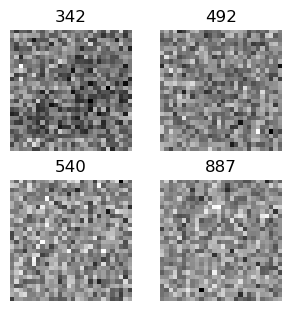

In [10]:
xt, t, epsilon = noisify(xb, alphabar)
show_images(xt, imsize=1.5, titles=t.tolist())

In [11]:
# ignore y, default_collate is the default collation function
def collate_ddpm(b):
    return noisify(default_collate(b)[x], alphabar)

def dl_ddpm(ds, bs):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

bs = 64
dls = DataLoaders(dl_ddpm(tds['train'], bs), dl_ddpm(tds['test'], bs))

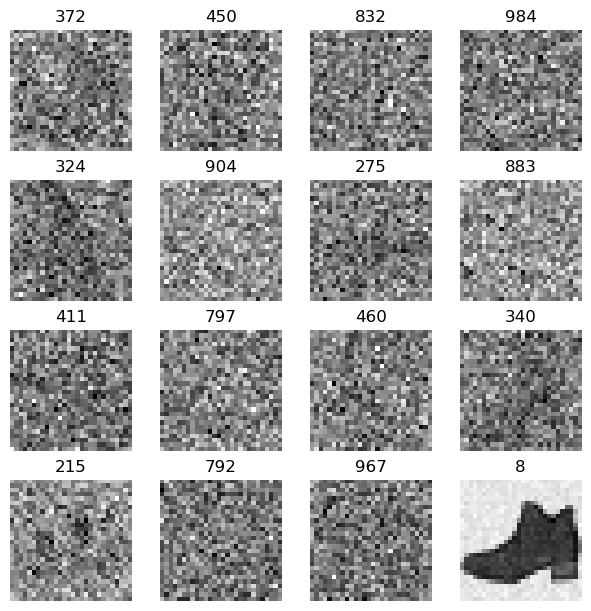

In [12]:
xb, t, e = next(iter(dls.train))
show_images(xb[:16], titles=t[:16].tolist(), imsize=1.5)

In [19]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample # type: ignore

def get_model(nfs=(16,32,64,64)):
    return UNet(in_channels=1, out_channels=1, block_out_channels=nfs, norm_num_groups=8)

model = get_model()
learn = Learner(model, dls, F.mse_loss)
learn.summary()

<generator object Module.children at 0x17ccf6c00>
[<tinyai.hooks.Hook object at 0x17cd5e710>, <tinyai.hooks.Hook object at 0x17cd5e380>, <tinyai.hooks.Hook object at 0x17cd5e2c0>, <tinyai.hooks.Hook object at 0x17cd5c910>, <tinyai.hooks.Hook object at 0x17cd5dcf0>, <tinyai.hooks.Hook object at 0x17cd5e200>, <tinyai.hooks.Hook object at 0x17cd5d2a0>, <tinyai.hooks.Hook object at 0x17aa0c7f0>, <tinyai.hooks.Hook object at 0x17aa0c250>]
Tot params: 0; MFLOPS: 0.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|


In [ ]:
learn

In [14]:
list(learn.model.children())

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Timesteps(),
 TimestepEmbedding(
   (linear_1): LoRACompatibleLinear(in_features=16, out_features=64, bias=True)
   (act): SiLU()
   (linear_2): LoRACompatibleLinear(in_features=64, out_features=64, bias=True)
 ),
 ModuleList(
   (0): DownBlock2D(
     (resnets): ModuleList(
       (0-1): 2 x ResnetBlock2D(
         (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
         (conv1): LoRACompatibleConv(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (time_emb_proj): LoRACompatibleLinear(in_features=64, out_features=16, bias=True)
         (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (conv2): LoRACompatibleConv(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (nonlinearity): SiLU()
       )
     )
     (downsamplers): ModuleList(
       (0): Downsample2D(
         (conv): LoRACompatibleConv(16, 16, kernel_size=(3, 3), s

In [15]:
nn.Sequential(nn.Linear(10,10), nn.ReLU(), nn.Linear(10, 1)).children()

<generator object Module.children at 0x17a7a22d0>